In [1]:
import ast
import random
import math
import string
import os
import json
from tqdm import tqdm
import networkx as nx
import pickle
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sys
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
#www.python-graph-gallery.com

In [2]:
INGREDIENT_TO_REPLACE = 'soy'#'palm oil'#'palm oil'#'peanut'#palm oil'#'palm oil'#'soya'#'peanut'#'palm oil''peanut'#'wheat'#'wheat'#'soya'#
USE_STANDARD_DATA = False
SAVE_STANDARD_DATA = True
USE_FREQUENCY = False
MASK = False
LOAD_SUB_FROM_FILE = False
USE_FREQUENCY = False
LOAD_BALANCED_DATA = False
STEM = True
REPLACE = True
REMOVE_REPLACE = False
SUBSET_PERC = 0.5
perc_for_print = str(SUBSET_PERC).split('.')[1]
root_to_standard_data = f'UNBALANCED_LINK_{INGREDIENT_TO_REPLACE}_{perc_for_print}_percent_of_data_final_saved_balanced_dataset.csv'
print(root_to_standard_data)


UNBALANCED_LINK_soy_55_percent_of_data_final_saved_balanced_dataset.csv


In [3]:
#os.environ['CUDA_LAUNCH_BLOCKING']="1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:

if STEM:
    ps = PorterStemmer()
    words = [ps.stem(word) for word in INGREDIENT_TO_REPLACE.split(' ')]
    s = ''
    for word in words:
        s += word

if REPLACE:
    with open('replace_words.json') as f:
        replacements = json.load(f)
        for each in replacements.keys():
            replacements[each] = ast.literal_eval(replacements[each])
    
if LOAD_SUB_FROM_FILE:
    df = pd.read_csv('final_saved_balanced_dataset.csv')
else:
    files = [
        "outputs/food_1_Y.csv",
        "outputs/food_2_Y.csv",
        "outputs/food_3_Y.csv"
    ]

    df = pd.DataFrame()
    for file in files:
        df = pd.concat([df, pd.read_csv(file)])

    #df = df[df.index < int(len(df.index)/50)]
    df = df.sample(frac=SUBSET_PERC, random_state=123456789)
    #df = df.dropna()
    df = df.reset_index()

with open('stopwords.txt', 'r') as f:
    stopwords = []
    for l in f:
        if l not in stopwords:
            stopwords.append(l.replace('\n',''))
#Add a list of the ingredients, and concatenate palm oil products to be just palm oil
ingredients = [[x.lower() for x in ast.literal_eval(product['ingredients'])] for _,product in df.iterrows()]
df['ingredients_list'] = ingredients



drop_sparse_idx = []
c = []
banned_words = ['nan', 'none', 'na']
trans = str.maketrans(string.punctuation, ' '*len(string.punctuation))
for row_idx, row in tqdm(df.iterrows()):
    if row['brand'] == math.nan:
        drop_sparse_idx.append(row_idx)
    len_ing = len(row['ingredients_list'])
    if len_ing==0:
        drop_sparse_idx.append(row_idx)
    elif len_ing == 1 and row['ingredients_list'][0].lower() in banned_words:
        drop_sparse_idx.append(row_idx)
    else:        
        idx = 0
        idx_to_remove = []
        while idx<len(row['ingredients_list']):
            if idx>1000:
                print(row['ingredients_list'][idx])
            row['ingredients_list'][idx] = row['ingredients_list'][idx].translate(trans)           
            if row['ingredients_list'][idx] in replacements.keys():
                #NEED TO DO THIS. SIMPLE GET THE VALUES IN replacements. CAN'T APPEND IN LOOP, BUT YOU COULD DO A WHILE LOOP
                idx_to_remove.append(idx)
                row['ingredients_list'].extend(replacements[row['ingredients_list'][idx]])             
            idx+=1
        if REMOVE_REPLACE:
            for i in reversed(idx_to_remove):
                row['ingredients_list'].pop(i)

df = df.drop(drop_sparse_idx)
drop_sparse_idx = []
for row_idx, row in tqdm(df.iterrows()):
    pop_li = []
    for idx, each in enumerate(row['ingredients_list']):
        stop_row_li = np.array(row['ingredients_list'][idx].split(' '))
        for stopword in stopwords:
            stop_loc = np.where(stop_row_li ==stopword)
            if len(stop_loc[0])>0:
                stop_row_li= np.delete(stop_row_li,stop_loc)
                str_ = ''
                for stringify_ in stop_row_li:
                    str_ += ' ' + stringify_
                row['ingredients_list'][idx] = str_
        if STEM:
            sentence = row['ingredients_list'][idx]
            words = [ps.stem(word) for word in sentence.split(' ')]
            s = ''
            for word in words:
                s += word
            row['ingredients_list'][idx] = s
            row['ingredients_list'][idx] = row['ingredients_list'][idx].replace(' ', '')
        if row['ingredients_list'][idx] == '':
            pop_li.append(idx)
        else:
            each = row['ingredients_list'][idx]
            if all(item in each.lower() for item in INGREDIENT_TO_REPLACE.lower().split()):
                c.append(each.lower())
                row['ingredients_list'][idx] = INGREDIENT_TO_REPLACE.lower()
    if pop_li:
        for each in reversed(pop_li):
            row['ingredients_list'].pop(each)
        if len(row['ingredients_list']) == 0:
            drop_sparse_idx.append(row_idx)

df = df.drop(drop_sparse_idx)

df = df[['index', 'name','brand','categories','price_max','price_min','ingredients','ingredients_list']]
df = df.dropna()
df

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (38,39,40,41,42,43,44,45,46,47,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,

,index,name,brand,categories,price_max,price_min,ingredients,ingredients_list
0,4184,BANQUET Frozen Chicken Breast Patties Made Wit...,Banquet,"['Grocery', 'Grocery & Gourmet Food', 'Breast ...",5.39,3.88,"['water', 'sodium bicarbonate', 'yeast', 'corn...","[water, sodiumbicarbon, yeast, cornstarch, whe..."
1,4487,COLMANS Original English Mustard,Colman's,"['Grocery & Gourmet Food', 'English Mustard', ...",19.73,4.49,"['water', 'mustard flour', 'sugar', 'salt', 'w...","[water, mustardflour, sugar, salt, wheatflour,..."
2,4137,Against The Grain Three Cheese Pizza,Against The Grain,"['Pizza', 'Grocery & Gourmet Food', 'Frozen']",100.32,100.32,"['crust tapioca starch', 'milk', 'eggs', 'cano...","[crusttapiocastarch, milk, egg, canolaoil, che..."
4,1381,NESTLE COFFEE-MATE Coffee Creamer,Nestle Coffee Mate,"['Grocery & Gourmet Food', 'Dairy', ' Cheese &...",22.72,17.48,"['water', 'sugar', 'coconut oil', 'sodium case...","[water, sugar, coconutoil, sodiumcasein, dipot..."
5,1493,Planters Peanuts,Planters,"['Grocery', 'Cooking & Baking', 'Nuts & Trail ...",9.99,9.95,"['peanut andor cottonseed oil', 'peanuts', 'al...","[peanutcottonseoil, peanut, almond, cashew, pi..."
...,...,...,...,...,...,...,...,...
10991,9828,Merenda Hazelnut Spread,Pavlidis,"['Jams', ' Jellies & Sweet Spreads', 'Grocery ...",13.10,13.10,"['sugar', 'peanut oil', 'hazelnuts', 'skim mil...","[sugar, peanutoil, hazelnut, milk, cocoa, soy]"
10992,10380,Honest Syrup,ChocZero,"['Cooking & Baking', 'Syrups', ' Sugars & Swee...",29.48,29.48,"['liquid vegetable fiber', 'caramel', 'monk fr...","[vegetfiber, caramel, monkfruitextract, carame..."
10993,2859,Thick-It Aquacare H2O Nectar Consistency Thick...,THICK-IT,"['Fruit Juice', 'Grocery & Gourmet Food', 'Hea...",40.00,35.48,"['artesian mineral water', 'xanthan gum', 'pot...","[artesianminerwater, xanthangum, potassiumsorb..."
10994,8793,Gerber 2nd Foods Pears,Gerber,"['Baby & Child', 'Cereal and Food', 'Food and ...",2.09,1.99,"['ascorbic acid', 'pear puree concentrate', 'c...","[ascorbacid, pear, citricacid, pearwater, pear..."


In [5]:
brand = {}
num_palm = 0
for idx,row in df.iterrows():
    for each in row['ingredients_list']:
        if INGREDIENT_TO_REPLACE in each.lower():
            #print("Name: %s ## Ingredient: %s" % (row['name'], each))            
            num_palm += 1
            br = row['brand']
            brand[br] = brand[br] + 1 if br in brand.keys() else 1
print(num_palm/len(df.index), len(df.index)/len(df.index))

0.724812834224599 1.0


In [6]:
#df = df[["name", "ingredients"]]
df = df.drop_duplicates(subset="name")
df = df.reset_index()


#unique_ingred = np.unique(sum(df["ingredients"].apply(ast.literal_eval).values.tolist(), []))
unique_names = df['name'].unique()
unique_brands = df['brand'].unique()
#unique_mans = df['manufacturer'].unique()
unique_cats = np.unique(sum(df["categories"].apply(ast.literal_eval).values.tolist(), []))
unique_names = sorted(unique_names)
#unique_ingred = sorted(unique_ingred)

unique_ingred = []
for x in df['ingredients_list']:
    for y in x:
        if y not in unique_ingred:
            unique_ingred.append(y)

In [7]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv
from torch.nn import Linear
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling, to_networkx
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score,precision_score, recall_score, f1_score


In [8]:
def get_feature_vector_and_label(product, decision_ingredients):
  #Build feature vector of high entropy ingredients. 
  feature_vector = np.zeros(len(decision_ingredients))
  ingredients = product['ingredients_list']#ast.literal_eval(product['ingredients'])
  for dec_idx,decision_ingr in enumerate(decision_ingredients):
    #Check if ingredients is in feature list, and also make sure to mask the palm oil ingredient
    if unique_ingred[dec_idx] in ingredients and unique_ingred[dec_idx] != INGREDIENT_TO_REPLACE:      
      feature_vector[dec_idx] = 1
  #1 = palmy, 0 = non_palmy
  label = 1 if INGREDIENT_TO_REPLACE in ingredients else 0

  return (feature_vector, label)

def get_cat_and_price(product):
  #get category data
  cat_data = ast.literal_eval(product['categories'])
  #Get mean price
  price_data = (product['price_min']+product['price_max']) / 2
  return {'cat':cat_data, 'price':price_data}

In [9]:
def get_adj_matrix_from_features(feature_mat):
    adj_mat = np.zeros((len(unique_names), len(unique_names)), dtype=int)
    for idx, col in enumerate(feature_mat.T):
        elements = np.where(col==1)[0]
        for i in elements:
            for j in elements:
                adj_mat[i,j] += 1 if i!=j else 0 
    return adj_mat

def get_adj_matrix_from_extra_features(feature_mat):
    adj_mat = np.zeros((len(unique_names), len(unique_names)), dtype=int)
    shared_features = np.zeros((len(unique_names), len(unique_names)), dtype=int)
    for idx, col in enumerate(feature_mat.T):
        elements = np.where(col==1)[0]
        for i in elements:
            for j in elements:
                adj_mat[i,j] += 1 if i!=j else 0
                shared_features[i,j] = idx
    return (adj_mat, shared_features)
       

In [10]:
def get_feature_matrix():
    feature_mat = np.zeros((len(unique_names),len(unique_ingred)),dtype=int)
    for idx, row in df.iterrows():
        ingr = row['ingredients_list']
        for ing_idx,each in enumerate(unique_ingred):
            feature_mat[idx,ing_idx] = 1 if each in ingr else 0
    return feature_mat

def get_feature_coocurrance():    
    feature_mat = dict()
    for each in range(len(unique_ingred)):
        feature_mat[each] = np.zeros((len(unique_ingred)),dtype=int)

    for idx, row in df.iterrows():
        ingr = row['ingredients_list']#ast.literal_eval(row['ingredients'])
        for ing_idx,each in enumerate(unique_ingred):
            if each in ingr:
                for ing_idx2,each2 in enumerate(unique_ingred):
                    if each2 in ingr:
                        #Minus the value along the diagonal. Prevents inteference with the coocurrance but also allows us to retrieve magnitude later
                        feature_mat[ing_idx][ing_idx2] += 1 if ing_idx!=ing_idx2 else -1
    return feature_mat

def get_information_entropy(cooccurance_matrix, palm_oil_idx, num_palm_oil, num_total_products):
    #Intuition: use information entropy to calculate how much information each other ingredient can give us on the presence of palm oil
    # - (P(palm_oil_presence|x) log(P(palm_oil_presence|x))) + (P(¬palm_oil_presence|x) log(P(¬palm_oil_presence|x)))
    def calculate_entropy(palm_presence, n):
        if n != 0:
            p1 = palm_presence/n
        else:
            p1 = 0
        p2 = 1-p1
        sum1 = 0 if p1==0 else (p1*math.log2(p1))
        sum2 = 0 if p2==0 else (p2*math.log2(p2))
        return - sum1 + sum2
    
    def calcalate_conditional_entropy(palm_presence, n, p_n):
        if p_n < 0:
            print(p_n)
            exit()
        if n!= 0:
            p1 = (palm_presence/n)*p_n
        else:
            p1 = 0
        assert p1 >=0
        assert p_n >=0
        sum1 = 1 if (p1<=0 or p_n<=0) else (1 + (p1*math.log2(1+(p1/p_n))))
        if sum1 <= 0:
            print(p1, p_n, palm_presence, n)
        return sum1

    n = len(unique_ingred)
    entropies = np.empty(n) 
    for idx,each in enumerate(cooccurance_matrix[palm_oil_idx]):
        if idx == palm_oil_idx:
            entropies[idx] == 100
        else:
            n_occ = -cooccurance_matrix[idx][idx]
            assert n_occ >= each, (unique_ingred[idx])
            entropies[idx] = (calcalate_conditional_entropy(each, n_occ, n_occ/num_total_products) + 
                                calcalate_conditional_entropy(each, num_total_products-n_occ, (num_total_products-n_occ)/num_total_products) + 
                                calcalate_conditional_entropy(n_occ-each, n_occ, n_occ/num_total_products) + 
                                calcalate_conditional_entropy(n_occ-each, num_total_products-n_occ, (num_total_products-n_occ)/num_total_products)
                                )
    return entropies

def frequency_weighted_conditional_entropies(cooccurance_matrix, ordered_entropy, entropies):
  frequency_weighted_conditional_entropies = []
  total_products = len(df.index)
  fs = []
  min_frequency = 0.00
  for idx in ordered_entropy:
      #Minus as you've made the diagonal minus for other reasons      
      if cooccurance_matrix[idx][idx]!=0:
          frequency = (-cooccurance_matrix[idx][idx])/total_products
          fs.append(frequency)
          if frequency >= min_frequency:
              occurance = np.log(1/frequency)
              if occurance < 0:
                  print("yes")
              
              frequency_weighted_conditional_entropies.append(occurance*entropies[idx])
          else:
              frequency_weighted_conditional_entropies.append(1.0)
  return frequency_weighted_conditional_entropies

def apply_entropy_mask(feature_matrix,top_n=2000, frequency_weighted=True):
  cooccurance_matrix = get_feature_coocurrance()
  #Print the highest co-occuring ingredients
  for idx,each in enumerate(unique_ingred):
      if (INGREDIENT_TO_REPLACE in each.lower()):
          palm_idx = idx
          palm_vector = cooccurance_matrix[idx]
          sorted_indicies = sorted(range(len(palm_vector)), key=lambda x: palm_vector[x], reverse=True)
          print("MOST CO-OCCURANCES: ",[(unique_ingred[x],palm_vector[x]) for x in sorted_indicies[:10]])
          break
  entropies = get_information_entropy(cooccurance_matrix, palm_idx, num_palm,len(df.index))
  ordered_entropy = sorted(range(len(entropies)), key=lambda x: entropies[x], reverse=False)
  
  if frequency_weighted:
    fwce = frequency_weighted_conditional_entropies(cooccurance_matrix, ordered_entropy, entropies)
    fwce_ordered_entropy = sorted(range(len(entropies)), key=lambda x: fwce[x], reverse=False)
    unique_ingred_ = [unique_ingred[i_] for i_ in fwce_ordered_entropy[:top_n]]
    feature_matrix = get_feature_matrix() 
    return feature_matrix, fwce_ordered_entropy, unique_ingred_
  else:
    unique_ingred_ = [unique_ingred[i_] for i_ in ordered_entropy[:top_n]]
    feature_matrix = get_feature_matrix() 
    return feature_matrix, ordered_entropy, unique_ingred_


In [11]:
def get_balanced_dataset(df):
  df = df.drop('level_0', axis=1).reset_index()
  palmy_prods = []
  for idx,row in df.iterrows():
    for each in row['ingredients_list']:    
      if (INGREDIENT_TO_REPLACE in each):
        palmy_prods.append(row)

  palmy_df = pd.DataFrame(palmy_prods)
  #Sample the same amount of non-palmy products

  df = df.drop(list(palmy_df.index))
  palmy_df = palmy_df.drop_duplicates(subset='index')
  sample_len = len(palmy_df.index)
  non_palmy_df = df.sample(sample_len)
  assert len(palmy_df.index) == len(non_palmy_df.index)
  frame = pd.concat([palmy_df, non_palmy_df]).drop('level_0', axis=1)
  frame = frame.reset_index().drop('level_0', axis=1)
  return frame

if USE_STANDARD_DATA:
  df = pd.read_csv(root_to_standard_data,converters={'ingredients_list': pd.eval})
elif SAVE_STANDARD_DATA:
  df = get_balanced_dataset(df)
  df.to_csv(root_to_standard_data)
# else:
#   df = get_balanced_dataset(df)

unique_ingred = []
for x in df['ingredients_list']:
    for y in x:
        if y not in unique_ingred:
            unique_ingred.append(y)

#Don't need ingredients, now that we have the ingredients list column
df = df.drop('ingredients', axis=1)
#Get Matrix of Features -- Products x Features
feature_matrix = []
label_vector = []
for idx, product in df.iterrows():
  feature_vector, label = get_feature_vector_and_label(product, unique_ingred)#get_feature_vector_and_label_with_brands(product, unique_ingred)
  feature_matrix.append(feature_vector)
  label_vector.append(label)



if MASK:
  feature_matrix,ordered_entropy,unique_ingred=apply_entropy_mask(feature_matrix,int(len(unique_ingred)/2), frequency_weighted=USE_FREQUENCY)

feature_matrix = []
label_vector = []
for idx, product in df.iterrows():
  feature_vector, label = get_feature_vector_and_label(product, unique_ingred)#get_feature_vector_and_label_with_brands(product, unique_ingred)
  feature_matrix.append(feature_vector)
  label_vector.append(label)
feature_matrix = torch.tensor(feature_matrix, dtype=torch.float)
label_vector = torch.tensor(label_vector)

#Get The category and price information for each node. Used to define edges
node_data_for_edges = np.array([get_cat_and_price(product) for _, product in df.iterrows()])
edge_index = []
edge_data = []
price_range = 0.1 #Prices must be within 20%
for from_ in tqdm(range(len(node_data_for_edges))):
  row = df.iloc[[from_]]
  for r in row['ingredients_list']:
    for each in r:
      if each==INGREDIENT_TO_REPLACE:
        #if 'palm oil' in list(df.iloc[[from_]]['ingredients_list']):
        for to_ in range(len(node_data_for_edges)):
          is_palm = False
          for to_row in df.loc[[to_]]['ingredients_list']:
            for to_each in to_row:
              if to_each == INGREDIENT_TO_REPLACE:
                is_palm = True
          if not is_palm:
            #Check if they are similar price
            price_ratio = node_data_for_edges[from_]['price']/node_data_for_edges[to_]['price']
            if (price_ratio >= 1-price_range) and (price_ratio <= 1+price_range):
              #Check if they are in the same category
              for cat_ in node_data_for_edges[from_]['cat']:
                if cat_ in node_data_for_edges[to_]['cat']:
                  if from_ == to_:
                    print(df.iloc[[to_]])
                  edge_index.append([from_, to_])
                  edge_data.append([cat_, price_ratio])
                  #TODO IMPORTANT: WILL ONLY EVER USE 1 CATEGORY HERE. EVEN IF MULTIPLE ARE SHARED
                  break
        break

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
#edge_data = torch.tensor(edge_data)
transform = T.Compose([
  T.ToDevice(device),
  T.RandomLinkSplit(num_val=0.1,num_test=0.1,is_undirected=False, add_negative_train_samples=False)  
])



data, val_data, test_data = transform(Data(x=feature_matrix, y=label_vector,edge_index=edge_index))

#dataset = ProductDataset(data, transform=transform)
#dataloader = DataLoader(dataset, 
print(data)
print(data.edge_index[:,:10])


100%|██████████| 4538/4538 [46:22<00:00,  1.63it/s]  


Data(x=[4538, 8945], edge_index=[2, 224505], y=[4538], edge_label=[224505], edge_label_index=[2, 224505])
tensor([[1228, 1997, 1707,  233, 2171, 2258, 2184, 1336, 1938, 2185],
        [2498, 4115, 2433, 4413, 3350, 3650, 3417, 3230, 4093, 2667]],
       device='cuda:0')


In [12]:
print(data.edge_index[:,:10])



tensor([[1228, 1997, 1707,  233, 2171, 2258, 2184, 1336, 1938, 2185],
        [2498, 4115, 2433, 4413, 3350, 3650, 3417, 3230, 4093, 2667]],
       device='cuda:0')


In [13]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

class SAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

    def get_links(self, z, edge_label_index):
        decoded = self.decode(z, edge_label_index).view(-1).sigmoid()
        preds = torch.Tensor([0 if x<0.5 else 1 for x in decoded]).to(device)
        print(preds.shape)


        

In [14]:
# num_features = len(data.x[0])

# model = SAGENet(num_features, 128, 64).to(device)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
# criterion = torch.nn.BCEWithLogitsLoss()

In [15]:
# def train():
#       model.train()
#       optimizer.zero_grad()  # Clear gradients.
#       #palm_oil_mask = np.where(data.y.cpu().numpy()==1)[0]
#       # data_edge_index = data.edge_index[palm_oil_mask]
#       # data_edge_label = data.edge_label[palm_oil_mask]
#       # data_edge_label_index = data.edge_label_index[palm_oil_mask]
      
      
#       z=model.encode(data.x, data.edge_index)
#       #print(data.edge_index.size(),data.edge_label.size(1),len(data.x))
#       neg_edge_index = negative_sampling(edge_index=data.edge_index, num_nodes=len(data.x), num_neg_samples=data.edge_label_index.size(1), method="sparse")
#       edge_label_index = torch.cat([data.edge_label_index, neg_edge_index], dim=-1)
#       edge_label = torch.cat([data.edge_label, data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)


#       out = model.decode(z,edge_label_index).view(-1)
#       loss = criterion(out,edge_label)
#       # out = model.decode(z,data.edge_label_index).view(-1)
#       # loss = criterion(out, data.edge_label)
#       loss.backward()
#       optimizer.step()
#       preds = out.cpu().detach().numpy()
#       preds = np.array([0 if x<0.5 else 1 for x in preds])
#       acc =  float(len(np.where(preds==edge_label.cpu().numpy())[0]))/len(preds)
#       return loss


# @torch.no_grad()
# def test():
#       model.eval()
#       z = model.encode(test_data.x, test_data.edge_index)
#       neg_edge_index = negative_sampling(edge_index=test_data.edge_index, num_nodes=len(test_data.x), num_neg_samples=test_data.edge_label_index.size(1), method="sparse")
#       edge_label_index = torch.cat([test_data.edge_label_index, neg_edge_index], dim=-1)
#       edge_label = torch.cat([test_data.edge_label, test_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
#       out = model.decode(z, edge_label_index).view(-1).sigmoid()
      
#       preds = out.cpu().numpy()
#       preds = np.array([0 if x<0.5 else 1 for x in preds])
#       el = edge_label.cpu().numpy()
#       o =  out.cpu().numpy()
#       acc =  float(len(np.where(preds==edge_label.cpu().numpy())[0]))/len(preds)
#       #print(len(np.where(o>=0.5)[0]), len(np.where(o<=0.5)[0]), len(o))
#       return roc_auc_score(edge_label.cpu().numpy(), out.cpu().numpy()), acc      




# # for epoch in range(1,500):
# #       loss=train()
# #       test_auc, acc = test()
# #       print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
# #             f'Test AUC: {test_auc:.4f}', f'Test ACC: {acc:.4f}')

# # torch.save(model.state_dict(), './model_saves/link_pred/link_prediction_sage_model')

# # z = model.encode(test_data.x, test_data.edge_index)
# # final_edge_index = model.decode_all(z)
# # final_data = deepcopy(test_data)
# # final_data.edge_index = final_edge_index


# # def test():
# #       class_correct = [0,0]
# #       class_samples = [0,0]
# #       model.eval()
# #       out = model(data.x, data.edge_index, data.edge_weight)
# #       pred = out.argmax(dim=1)  # Use the class with highest probability.
# #       test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
# #       assert len(test_correct)==len(pred[data.test_mask])
# #       #print(test_correct)
# #       test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
# #       p = pred[data.test_mask]
# #       d = data.y[data.test_mask]
      
# #       for idx,each in enumerate(test_correct):          
# #           class_samples[p[idx]] += 1
# #           if each == True:
# #               class_correct[p[idx]] += 1
# #       print(class_correct, class_samples)
# #       print([class_correct[idx]/class_samples[idx] for idx in range(2)])
# #       return test_acc




In [16]:
# #Visualise random sample
# k = 100
# #Ground Truth Graph
# new_graph = to_networkx(test_data)
# print(len(new_graph.edges))
# sampled_nodes = random.sample(new_graph.nodes, k)
# nx.draw(new_graph)

In [17]:
# #Predicted Graph

# new_graph = to_networkx(final_data)
# sampled_graph = new_graph.subgraph(sampled_nodes)
# nx.draw(sampled_graph)


In [18]:

def grid_search(hidden_channels:list, out_channels:list,lrs:list,save_path:str):
    def train(optimizer, criterion):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      #palm_oil_mask = np.where(data.y.cpu().numpy()==1)[0]
      # data_edge_index = data.edge_index[palm_oil_mask]
      # data_edge_label = data.edge_label[palm_oil_mask]
      # data_edge_label_index = data.edge_label_index[palm_oil_mask]
      
      
      z=model.encode(data.x, data.edge_index)
      #print(data.edge_index.size(),data.edge_label.size(1),len(data.x))
      neg_edge_index = negative_sampling(edge_index=data.edge_index, num_nodes=len(data.x), num_neg_samples=data.edge_label_index.size(1), method="sparse")
      edge_label_index = torch.cat([data.edge_label_index, neg_edge_index], dim=-1)
      edge_label = torch.cat([data.edge_label, data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)


      out = model.decode(z,edge_label_index).view(-1)
      loss = criterion(out,edge_label)
      # out = model.decode(z,data.edge_label_index).view(-1)
      # loss = criterion(out, data.edge_label)
      loss.backward()
      optimizer.step()
      preds = out.cpu().detach().numpy()
      preds = np.array([0 if x<0.5 else 1 for x in preds])
      acc =  float(len(np.where(preds==edge_label.cpu().numpy())[0]))/len(preds)
      return loss
    
    @torch.no_grad()
    def test():
          model.eval()
          z = model.encode(test_data.x, test_data.edge_index)
          neg_edge_index = negative_sampling(edge_index=test_data.edge_index, num_nodes=len(test_data.x), num_neg_samples=test_data.edge_label_index.size(1), method="sparse")
          edge_label_index = torch.cat([test_data.edge_label_index, neg_edge_index], dim=-1)
          edge_label = torch.cat([test_data.edge_label, test_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
          out = model.decode(z, edge_label_index).view(-1).sigmoid()
          
          preds = out.cpu().numpy()
          preds = np.array([0 if x<0.5 else 1 for x in preds])
          el = edge_label.cpu().numpy()
          acc =  float(len(np.where(preds==edge_label.cpu().numpy())[0]))/len(preds)

          f1 = f1_score(edge_label.cpu().numpy(), preds)

          #print(len(np.where(o>=0.5)[0]), len(np.where(o<=0.5)[0]), len(o))
          return roc_auc_score(edge_label.cpu().numpy(), out.cpu().numpy()), acc, f1
    
    @torch.no_grad()
    def val():
          model.eval()
          z = model.encode(test_data.x, val_data.edge_index)
          neg_edge_index = negative_sampling(edge_index=val_data.edge_index, num_nodes=len(val_data.x), num_neg_samples=val_data.edge_label_index.size(1), method="sparse")
          edge_label_index = torch.cat([val_data.edge_label_index, neg_edge_index], dim=-1)
          edge_label = torch.cat([val_data.edge_label, val_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
          out = model.decode(z, edge_label_index).view(-1).sigmoid()

          preds = out.cpu().numpy()
          preds = np.array([0 if x<0.5 else 1 for x in preds])
          el = edge_label.cpu().numpy()
          o =  out.cpu().numpy()

          f1 = f1_score(edge_label.cpu().numpy(), preds)
          

          acc =  float(len(np.where(preds==edge_label.cpu().numpy())[0]))/len(preds)
          #print(len(np.where(o>=0.5)[0]), len(np.where(o<=0.5)[0]), len(o))
          return roc_auc_score(edge_label.cpu().numpy(), out.cpu().numpy()), acc,f1

    num_features = len(data.x[0])
    data_dict = {}
    end_str = INGREDIENT_TO_REPLACE
    data_dict[end_str] = {'train_loss':{}, 'Test Accuracy':{},'Test AUC':{}, 'Validation Accuracy':{}, 'Validation AUC':{}, 'Validation F1': {}, 'Test F1': {}}
    for hidden_chans in hidden_channels:
      for out_chans in out_channels:
        for lr in lrs:
          for i in range(25):
            model = SAGENet(num_features, hidden_chans, out_chans).to(device)
            optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
            criterion = torch.nn.BCEWithLogitsLoss()
            max_acc = 0.0
            max_auc = 0.0
            acc_li = []
            auc_li = []
            test_acc_li = []
            test_auc_li = []
            test_f1_li = []
            val_f1_li = []
            loss_li = []
            stop_at = 0
            for epoch in range(1,501):
              loss=train(optimizer,criterion)         
              loss_li.append(loss.cpu().detach().item())
              if (epoch%10)==0 or epoch==1:
                auc,acc,val_f1 = val()
                acc_li.append(acc)
                auc_li.append(auc)
                val_f1_li.append(val_f1)
                test_auc, test_acc,test_f1 = test()
                test_acc_li.append(test_acc)
                test_auc_li.append(test_auc)
                test_f1_li.append(test_f1)
                if acc > max_acc:
                  stop_at = epoch
                  max_auc = auc 
                  max_acc = acc 
              
              # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              #       f'Test AUC: {test_auc:.4f}',f'Max AUC: {max_auc:.4f}')

            print(f'{i} -- Hids: {hidden_chans} Outs: {out_chans} LR: {lr} Max AUC: {test_auc_li[int(stop_at/10)]:.4f} Max Acc: {test_acc_li[int(stop_at/10)]: .4f} Max F1: {test_f1_li[int(stop_at/10)]}')

            data_dict[end_str]['train_loss'][i] = loss_li
            data_dict[end_str]['Validation Accuracy'][i] = acc_li
            data_dict[end_str]['Validation AUC'][i] = auc_li
            data_dict[end_str]['Test Accuracy'][i] = test_acc_li
            data_dict[end_str]['Test AUC'][i] = test_auc_li
            data_dict[end_str]['Validation F1'][i] = val_f1_li
            data_dict[end_str]['Test F1'][i] = test_f1_li
            del(model)
          with open(save_path+f'{INGREDIENT_TO_REPLACE}_data_dict_entropy_stop_{stop_at}', 'wb') as f:
            pickle.dump(data_dict, f)
      
outs = [128] 
hids = [128] 
lrs = [0.001]
save_path = 'gridsearch/link/'
grid_search(hids,outs,lrs,save_path)

RuntimeError: CUDA out of memory. Tried to allocate 7.48 GiB (GPU 0; 8.00 GiB total capacity; 180.87 MiB already allocated; 6.34 GiB free; 202.00 MiB reserved in total by PyTorch)

In [ ]:
# new_graph = to_networkx(final_data)
# pos=nx.circular_layout(new_graph)
# nx.draw(new_graph, pos=pos)

tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
True


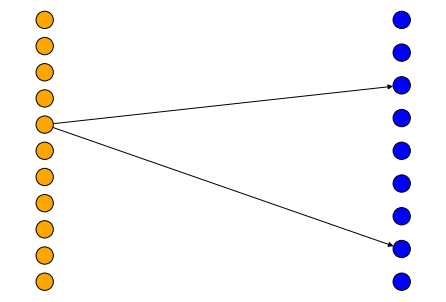

In [ ]:
print(data.y)
new_graph = to_networkx(data)
pos=nx.kamada_kawai_layout(new_graph)

k=20

sampled_nodes = random.sample(new_graph.nodes,k)

sampled_graph = new_graph.subgraph(sampled_nodes)

print(nx.is_bipartite(sampled_graph))

li = list(sampled_nodes)
cm = []
palm_list = []
o_c, b_c = 0,0
for node in sampled_graph:
    if data.y[node] ==1:
        cm.append('orange')
        palm_list.append(node)
        o_c+=1
    else:
        cm.append('blue')
        b_c+=1

pos=nx.bipartite_layout(sampled_graph, nodes=palm_list)
nx.draw(sampled_graph, node_color=cm, pos=pos, edgecolors='black')
